In [1]:
import json
import os
import cv2
from torch.utils.data import random_split, DataLoader

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.draw import ellipse
import matplotlib.pyplot as plt
import torch
import numpy as np

# Cleaning of the anotations

In [2]:
import json


def remove_annotations_without_ulcer(file_path, output_path):
    """
    Reads a JSON file of image annotations, removes entries without the "ulcer" annotation,
    and saves the cleaned data to a new JSON file. Prints the initial and final number of entries.

    Args:
        file_path (str): Path to the input JSON file with image annotations.
        output_path (str): Path to save the output JSON file with filtered annotations.

    Returns:
        str: Path to the output JSON file.
    """
    with open(file_path, "r") as f:
        data = json.load(f)

    # Initial number of entries
    initial_count = len(data)
    print(f"Initial number of IDs: {initial_count}")

    # Filter out entries without ulcer annotation
    filtered_data = [
        entry
        for entry in data
        if any(
            annotation["from_name"] == "ulcer"
            for annotation in entry.get("annotations", [])[0].get("result", [])
        )
    ]

    # Final number of entries
    final_count = len(filtered_data)
    print(f"Final number of IDs with 'ulcer' annotation: {final_count}")

    # Save filtered data to a new file
    with open(output_path, "w") as f:
        json.dump(filtered_data, f, indent=4)

    return output_path

# Model code

In [3]:
import cv2
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import os
import json
from skimage.draw import ellipse


class CorneaUlcerDataset(Dataset):
    def __init__(self, json_file, image_dir, transform=None, target_size=(256, 256)):
        with open(json_file, "r") as f:
            self.data = json.load(f)
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image_name = entry["file_upload"].split("-")[-1]
        img_path = os.path.join(self.image_dir, image_name)

        # Load the image in color
        raw_image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # Convert to RGB for further processing
        img_filt2 = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

        # Convert to grayscale to identify bright areas (reflections)
        grays = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)

        # Threshold to create a mask for bright reflections
        _, mask = cv2.threshold(grays, 200, 255, cv2.THRESH_BINARY)

        # Dilate the mask to expand the areas to be inpainted
        kernel = np.ones((10, 10), np.uint8)
        mask_dilated = cv2.dilate(mask, kernel, iterations=1)

        # Use inpainting to remove reflections
        image_processed = cv2.inpaint(img_filt2, mask_dilated, 7, cv2.INPAINT_TELEA)

        annotations = entry["annotations"][0]["result"]

        # Loop over results to find "Córnea" and "Úlcera"
        cornea_ellipse = None
        ulcer_polygons = []
        for result in annotations:
            if result["from_name"] == "cornea":
                cornea_ellipse = result["value"]
            elif result["from_name"] == "ulcer":
                ulcer_polygons.append(result["value"]["points"])

        # Crop Image based on ellipse
        if cornea_ellipse:
            x_center = int(cornea_ellipse["x"] / 100 * image_processed.shape[1])
            y_center = int(cornea_ellipse["y"] / 100 * image_processed.shape[0])
            radius_x = int(cornea_ellipse["radiusX"] / 100 * image_processed.shape[1])
            radius_y = int(cornea_ellipse["radiusY"] / 100 * image_processed.shape[0])

            mask = np.zeros(image_processed.shape[:2], dtype=np.uint8)
            rr, cc = ellipse(y_center, x_center, radius_y, radius_x)
            mask[rr, cc] = 255
            cropped_image = cv2.bitwise_and(image_processed, image_processed, mask=mask)
        else:
            cropped_image = image_processed

        # Resize cropped image to target size
        cropped_image = cv2.resize(
            cropped_image, self.target_size, interpolation=cv2.INTER_AREA
        )

        # Create binary mask from ulcer polygon
        mask = np.zeros(image_processed.shape[:2], dtype=np.uint8)
        for polygon in ulcer_polygons:
            points = [
                (
                    int(x / 100 * image_processed.shape[1]),
                    int(y / 100 * image_processed.shape[0]),
                )
                for x, y in polygon
            ]
            points = np.array([points], dtype=np.int32)
            cv2.fillPoly(mask, points, 255)

        # Resize mask to target size
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # Convert cropped image and mask to PIL images for transformations
        cropped_image = Image.fromarray(cropped_image)
        mask = Image.fromarray(mask)

        # Apply transformations if provided
        if self.transform:
            cropped_image = self.transform(cropped_image)
            mask = self.transform(mask)

        return cropped_image, mask, image_name

In [4]:
def load_data(json_path, img_dir, batch_size=8):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((256, 256))]
    )
    dataset = CorneaUlcerDataset(json_path, img_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def train_model(model, device, dataloader, num_epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks, _ in dataloader:
            # Move data to device -> TESTED IN M3
            images, masks = images.to(device), masks.to(device)

            images = images.float()
            masks = masks.float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

In [6]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, feature_base=64):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(in_channels, feature_base)
        self.encoder2 = self.conv_block(feature_base, feature_base * 2)
        self.encoder3 = self.conv_block(feature_base * 2, feature_base * 4)
        self.encoder4 = self.conv_block(feature_base * 4, feature_base * 8)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = self.conv_block(feature_base * 8, feature_base * 16)

        self.upconv4 = nn.ConvTranspose2d(
            feature_base * 16, feature_base * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self.conv_block(feature_base * 16, feature_base * 8)

        self.upconv3 = nn.ConvTranspose2d(
            feature_base * 8, feature_base * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self.conv_block(feature_base * 8, feature_base * 4)

        self.upconv2 = nn.ConvTranspose2d(
            feature_base * 4, feature_base * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self.conv_block(feature_base * 4, feature_base * 2)

        self.upconv1 = nn.ConvTranspose2d(
            feature_base * 2, feature_base, kernel_size=2, stride=2
        )
        self.decoder1 = self.conv_block(feature_base * 2, feature_base)

        # Final Convolution
        self.final_conv = nn.Conv2d(feature_base, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.pool(x1)
        x3 = self.encoder2(x2)
        x4 = self.pool(x3)
        x5 = self.encoder3(x4)
        x6 = self.pool(x5)
        x7 = self.encoder4(x6)
        x8 = self.pool(x7)

        # Bottleneck
        bottleneck = self.bottleneck(x8)

        # Decoder with skip connections
        d4 = self.upconv4(bottleneck)
        d4 = torch.cat((d4, x7), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, x5), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, x3), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, x1), dim=1)
        d1 = self.decoder1(d1)
        # Sigmoid for binary segmentation
        return torch.sigmoid(self.final_conv(d1))

In [7]:
def create_dataloaders(json_path, img_dir, batch_size=8, train_ratio=0.8):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((256, 256))]
    )

    # Load the full dataset
    dataset = CorneaUlcerDataset(json_path, img_dir, transform=transform)

    # Split the dataset
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [8]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    mps_device = torch.device("cpu")


json_path = "../data/image_anotations.json"
cleaned_anotations = remove_annotations_without_ulcer(
    file_path=json_path, output_path="../data/cleaned_anotations.json"
)
img_dir = "../data/raw"
train_loader, test_loader = create_dataloaders(
    cleaned_anotations, img_dir, batch_size=4
)


model = UNet().to(mps_device)
train_model(
    model, device=mps_device, dataloader=train_loader, num_epochs=200, lr=0.0001
)

tensor([1.], device='mps:0')
Initial number of IDs: 218
Final number of IDs with 'ulcer' annotation: 170
Epoch [1/200], Loss: 0.5282488430247587
Epoch [2/200], Loss: 0.3812168880420573
Epoch [3/200], Loss: 0.33254891721641316
Epoch [4/200], Loss: 0.30242908351561604
Epoch [5/200], Loss: 0.2925129269852358
Epoch [6/200], Loss: 0.2714034792254953
Epoch [7/200], Loss: 0.26086923786822486
Epoch [8/200], Loss: 0.25349555778152805
Epoch [9/200], Loss: 0.24117483812219956
Epoch [10/200], Loss: 0.233211590524982
Epoch [11/200], Loss: 0.22385809132281473
Epoch [12/200], Loss: 0.21186723034171498
Epoch [13/200], Loss: 0.2007927044349558
Epoch [14/200], Loss: 0.1930646199513884
Epoch [15/200], Loss: 0.18451045365894542
Epoch [16/200], Loss: 0.17876337468624115
Epoch [17/200], Loss: 0.17367680940557928
Epoch [18/200], Loss: 0.16613869588164723
Epoch [19/200], Loss: 0.16061830520629883
Epoch [20/200], Loss: 0.15343485991744435
Epoch [21/200], Loss: 0.14870208852431355
Epoch [22/200], Loss: 0.142656

In [9]:
def visualize_results(model, device, dataloader, num_samples=5):
    model.eval()  # Set model to evaluation mode
    model.to(device)

    with torch.no_grad():  # Disable gradient calculation for faster inference
        for i, (images, masks, image_names) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            # Generate predictions
            predictions = model(images)
            predictions = torch.sigmoid(predictions)

            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            predictions = predictions.cpu().numpy()

            # Plot each sample in the batch
            for j in range(min(num_samples, images.shape[0])):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                fig.suptitle(f"Image name {image_names[j]}")

                # Original image
                original_image = images[j].transpose(1, 2, 0)
                axes[0].imshow(original_image)
                axes[0].set_title("Original Image")
                axes[0].axis("off")

                # Ground truth mask
                gt_mask = masks[j][0]
                axes[1].imshow(original_image)
                axes[1].imshow(gt_mask, cmap="jet", alpha=0.5)
                axes[1].set_title("Ground Truth Mask Overlay")
                axes[1].axis("off")

                # Predicted mask
                pred_mask = predictions[j][0]
                axes[2].imshow(original_image)
                axes[2].imshow(pred_mask, cmap="jet", alpha=0.5)
                axes[2].set_title("Predicted Mask Overlay")
                axes[2].axis("off")

                plt.title("")
                plt.show()

            if i * dataloader.batch_size >= num_samples:
                break

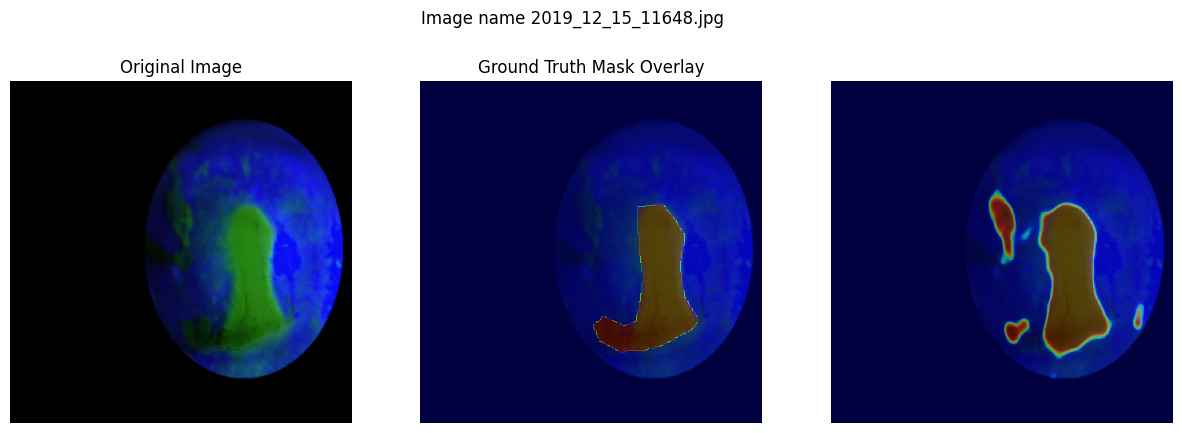

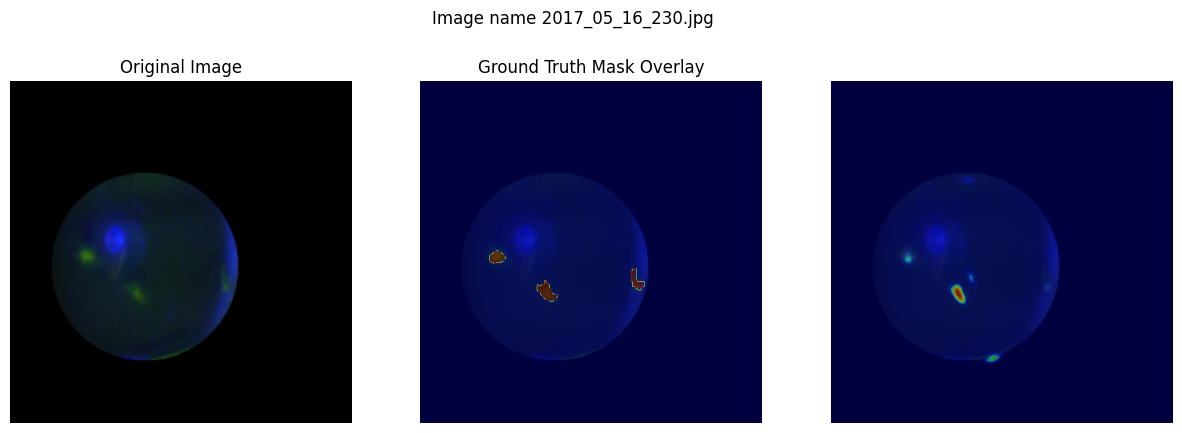

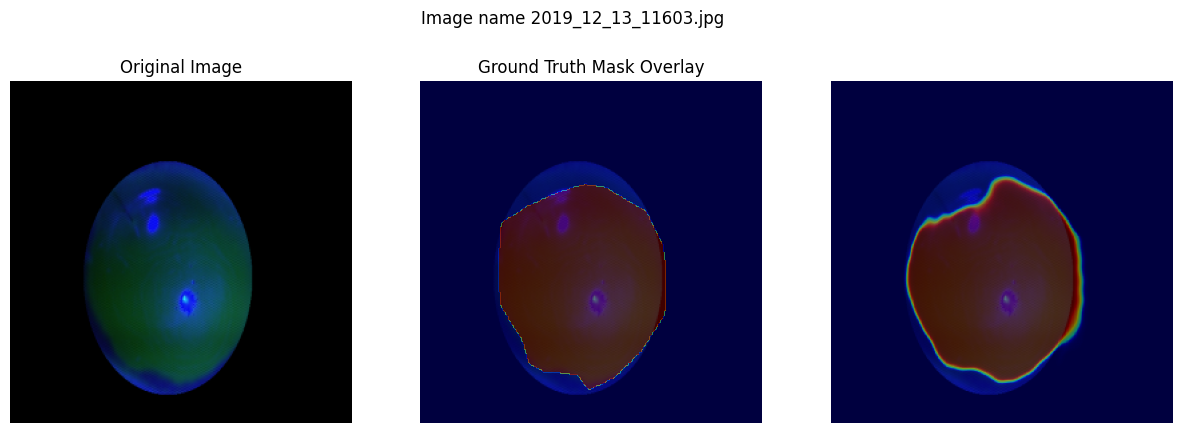

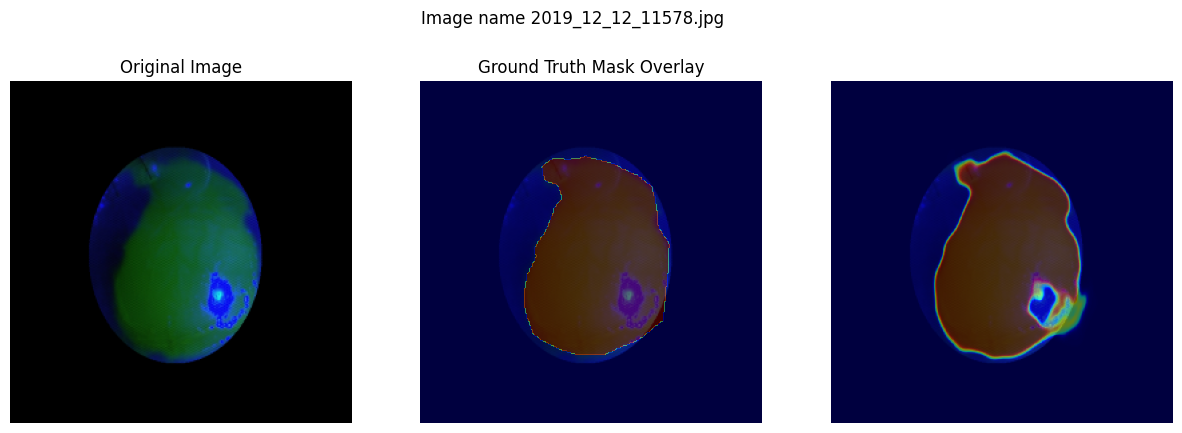

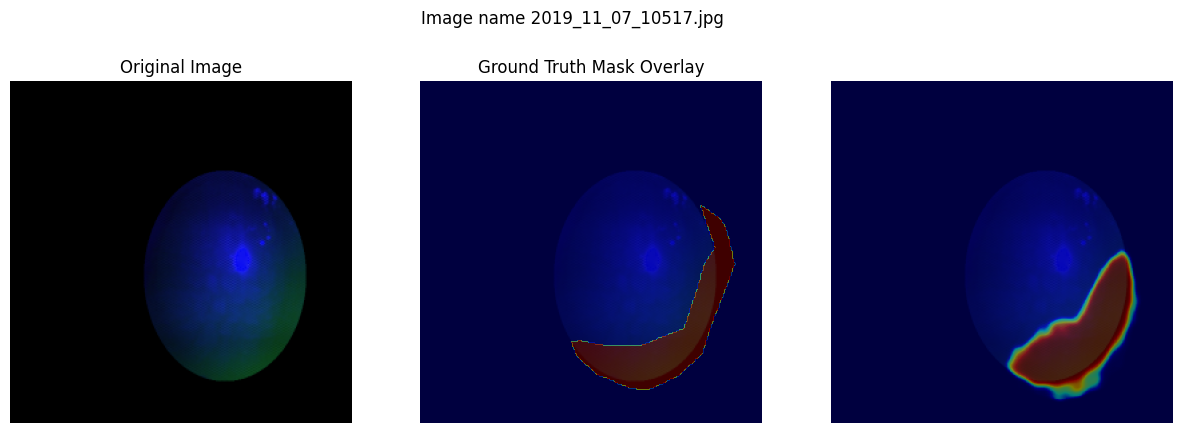

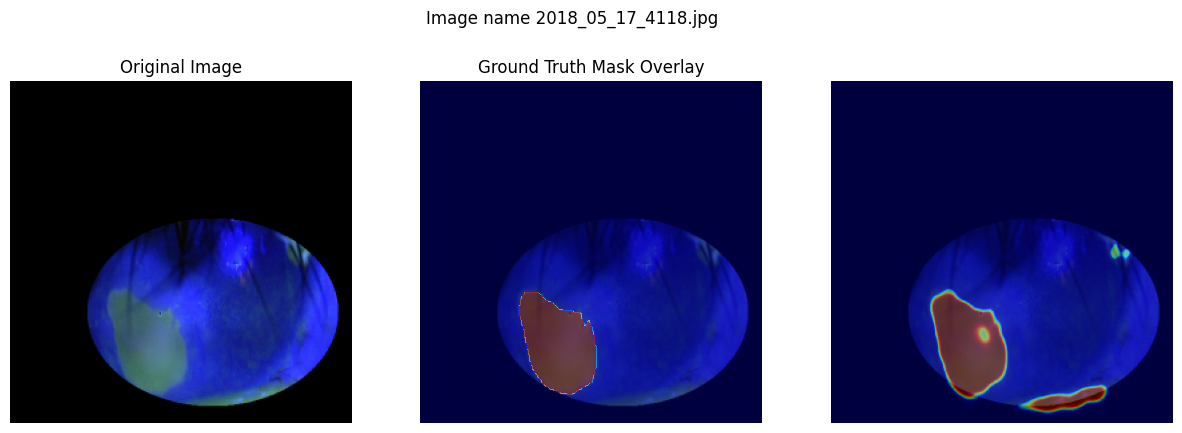

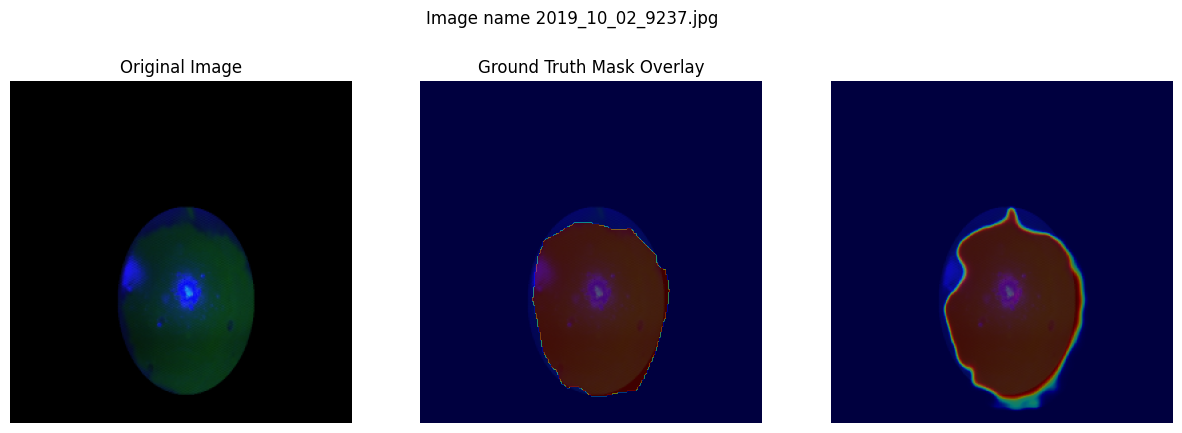

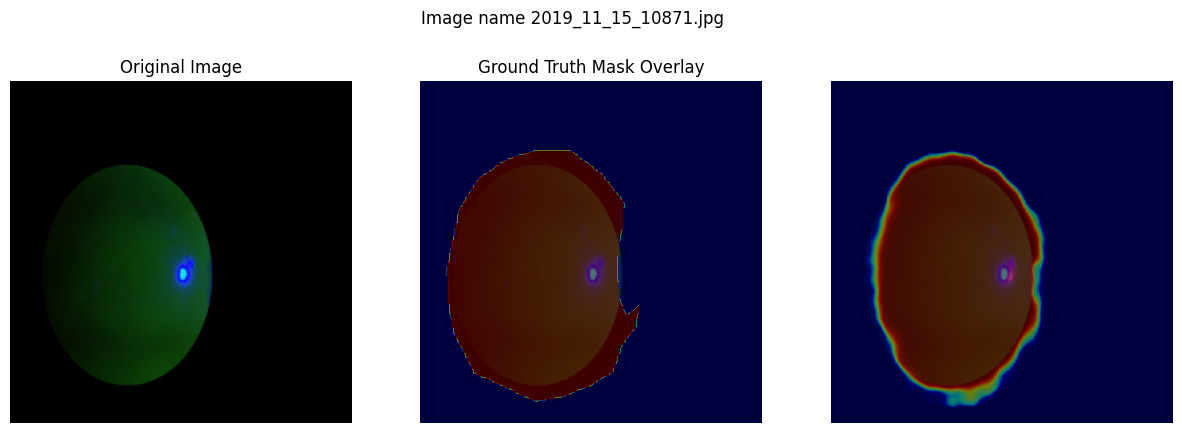

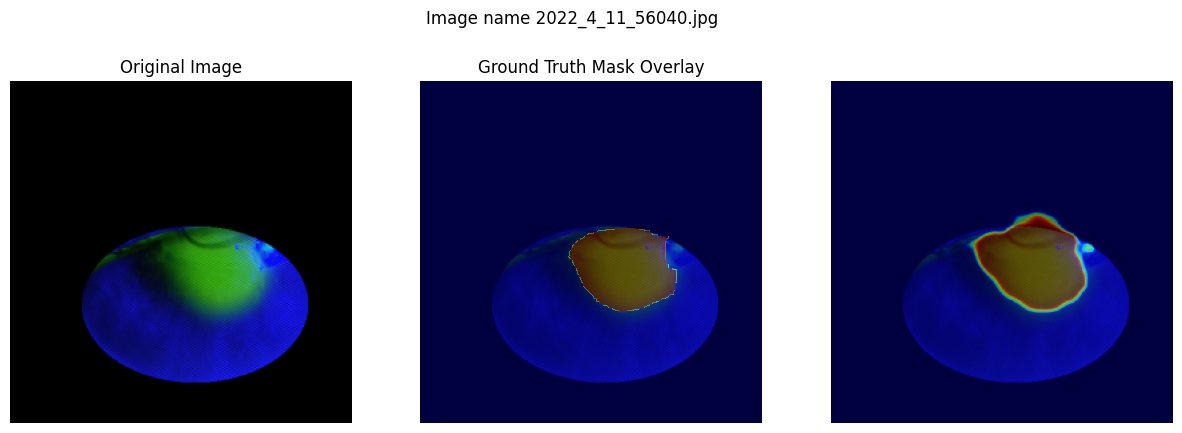

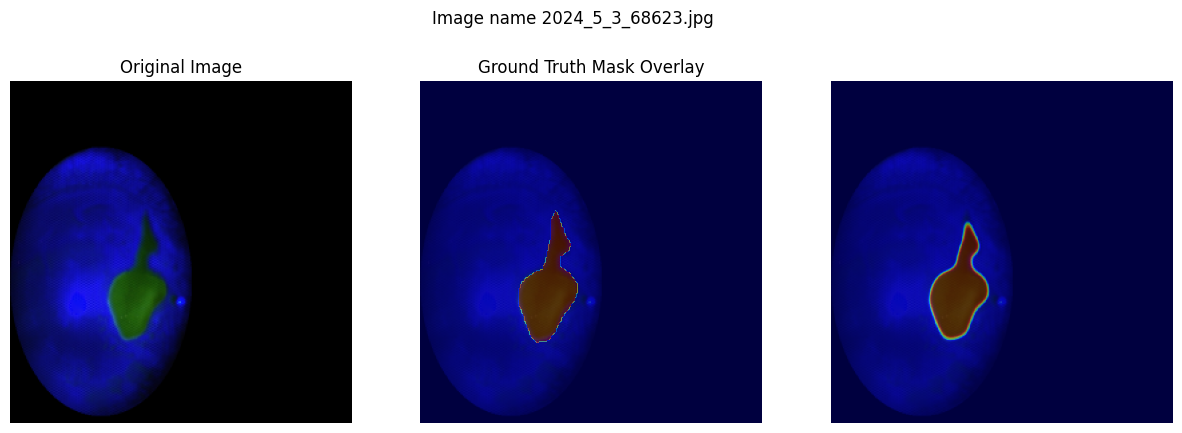

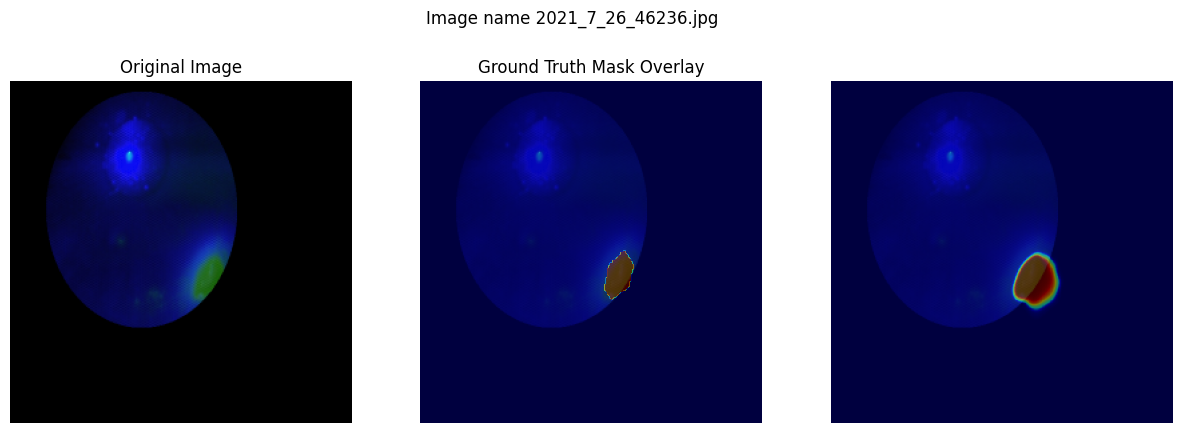

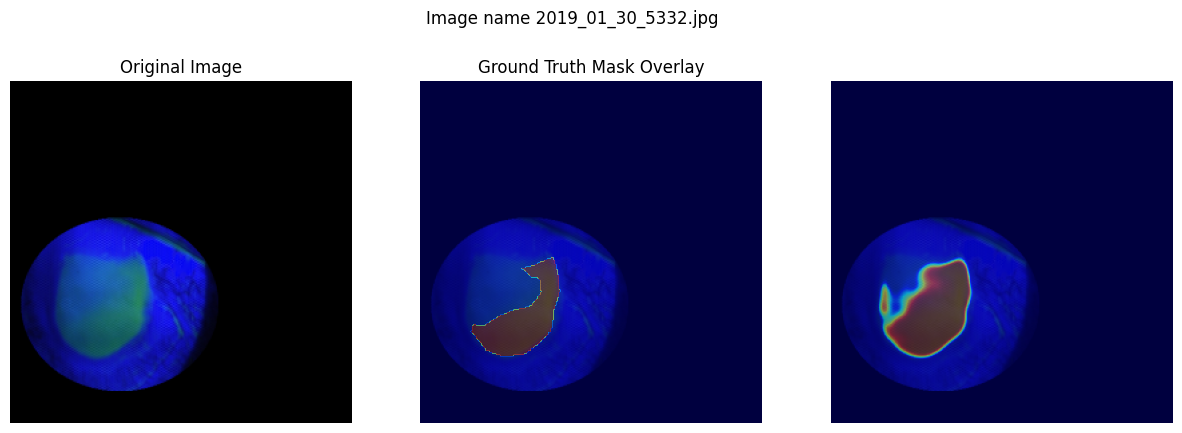

In [10]:
visualize_results(model, dataloader=test_loader, device=mps_device, num_samples=5)

# Metrics

In [11]:
def iou_score(pred, target, threshold=0.7):
    """Calculate Intersection over Union (IoU) score."""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection / union).item() if union != 0 else 0


def dice_score(pred, target, threshold=0.7):
    """Calculate Dice coefficient."""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (
        (2 * intersection / (pred.sum() + target.sum())).item()
        if (pred.sum() + target.sum()) != 0
        else 0
    )

In [12]:
def evaluate_model(model, device, dataloader):
    """Evaluate the model using IoU and Dice score."""
    model.eval()
    model.to(device)
    iou_total, dice_total, count = 0.0, 0.0, 0

    with torch.no_grad():
        for images, masks, _ in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            for i in range(images.size(0)):
                iou = iou_score(outputs[i], masks[i])
                dice = dice_score(outputs[i], masks[i])
                iou_total += iou
                dice_total += dice
                count += 1

    avg_iou = iou_total / count
    avg_dice = dice_total / count
    return {"IoU": avg_iou, "Dice": avg_dice}


train_metrics = evaluate_model(model, device=mps_device, dataloader=train_loader)
test_metrics = evaluate_model(model, device=mps_device, dataloader=test_loader)

print("Training Metrics:", train_metrics)
print("Testing Metrics:", test_metrics)

Training Metrics: {'IoU': 0.6698851186905385, 'Dice': 0.7484586175722892}
Testing Metrics: {'IoU': 0.6798059269785881, 'Dice': 0.7757091833388104}


# Conclusiones

Durante esta fase del proyecto, nos enfocamos en la creación de máscaras tanto para córneas como para úlceras con el fin de evaluar el desempeño del modelo en la segmentación con los datos disponibles. Un aspecto importante fue el procesamiento de las anotaciones en formato JSON, las cuales contenían imágenes tanto con como sin máscara. Esto nos llevó a considerar la posibilidad de desarrollar un flujo adicional de preprocesamiento para filtrar o procesar las imágenes adecuadamente según sus etiquetas de máscara.

Los primeros resultados en el conjunto de datos de prueba mostraron un desempeño de segmentación prometedor, logrando detecciones satisfactorias incluso con solo 50 imágenes etiquetadas. Estos resultados iniciales superaron nuestras expectativas, demostrando el potencial del modelo para identificar úlceras en imágenes no etiquetadas.

Los próximos pasos incluyen finalizar el proceso de creación de máscaras, así como limpiar y estructurar el JSON para obtener mediciones concluyentes. Además, continuaremos optimizando la base de datos y enfocándonos en mejorar las métricas de rendimiento del modelo. Esto nos permitirá evaluar cuantitativamente la precisión de nuestro enfoque y compararlo con los modelos del estudio original.
